In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')
plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif')
plt.rc('font', size=18)
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=18)
plt.rc('lines', markersize=10)

In [2]:
# Write a convolutional model that takes 31 19x19 planes as input and that outputs a vector of 361 with a softmax (the policy) and an output of 1 (the value)
# Train it on randomly generated data with different losses for the policy (categorical cross entropy) and the value (mse).

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model

In [4]:
class ResidualBlock(layers.Layer):
    def __init__(self, filters, kernel_size, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.conv1 = layers.Conv2D(filters, kernel_size, padding='same', activation='relu')
        self.conv2 = layers.Conv2D(filters, kernel_size, padding='same')
        self.add = layers.Add()
        self.activation = layers.Activation('relu')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.add([inputs, x])
        x = self.activation(x)
        return x


class PolicyHead(layers.Layer):
    def __init__(self, filters, kernel_size, **kwargs):
        super(PolicyHead, self).__init__(**kwargs)
        self.conv = layers.Conv2D(filters, kernel_size, padding='same', activation='relu')
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(361, activation='softmax')

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.flatten(x)
        x = self.dense(x)
        return x


class ValueHead(layers.Layer):
    def __init__(self, filters, kernel_size, **kwargs):
        super(ValueHead, self).__init__(**kwargs)
        self.conv = layers.Conv2D(filters, kernel_size, padding='same', activation='relu')
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(256, activation='relu')
        self.dense2 = layers.Dense(1, activation='tanh')

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return x

In [5]:
class AlphaZeroModel(models.Model):
    def __init__(self, **kwargs):
        super(AlphaZeroModel, self).__init__(**kwargs)
        self.conv1 = layers.Conv2D(256, 3, padding='same', activation='relu')
        self.res1 = ResidualBlock(256, 3)
        self.policy_head = PolicyHead(2, 1)
        self.value_head = ValueHead(1, 1)

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.res1(x)
        policy = self.policy_head(x)
        value = self.value_head(x)
        return policy, value

In [13]:
N = 10000 
planes = 31 
moves = 361
input_data = np.random.randint(2, size=(N, 19, 19, planes)) 
input_data = input_data.astype ('float32')
policy = np.random.randint(moves, size=(N,)) 
policy = tf.keras.utils.to_categorical(policy, num_classes=moves)
value = np.random.randint(2, size=(N,)) 
value = value.astype ('float32')

In [26]:
model = AlphaZeroModel()
model.compile(optimizer=optimizers.Adam(learning_rate=0.01), loss=['categorical_crossentropy', 'mse'])
model.fit(input_data, [policy, value], epochs=20, batch_size=128, validation_split=0.2)

Epoch 1/20


2023-11-08 15:00:22.941685: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - ETA: 0s - loss: 6.2049 - output_1_loss: 5.8909 - output_2_loss: 0.3140

2023-11-08 15:00:35.401692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 15s 188ms/step - loss: 6.2049 - output_1_loss: 5.8909 - output_2_loss: 0.3140 - val_loss: 6.1404 - val_output_1_loss: 5.8902 - val_output_2_loss: 0.2503
Epoch 2/20
63/63 [==============================] - 9s 141ms/step - loss: 6.1302 - output_1_loss: 5.8794 - output_2_loss: 0.2508 - val_loss: 6.1449 - val_output_1_loss: 5.8943 - val_output_2_loss: 0.2505
Epoch 3/20
63/63 [==============================] - 9s 141ms/step - loss: 6.1262 - output_1_loss: 5.8756 - output_2_loss: 0.2505 - val_loss: 6.1480 - val_output_1_loss: 5.8980 - val_output_2_loss: 0.2500
Epoch 4/20
63/63 [==============================] - 9s 141ms/step - loss: 6.1245 - output_1_loss: 5.8739 - output_2_loss: 0.2506 - val_loss: 6.1528 - val_output_1_loss: 5.9018 - val_output_2_loss: 0.2510
Epoch 5/20
63/63 [==============================] - 9s 141ms/step - loss: 6.1237 - output_1_loss: 5.8730 - output_2_loss: 0.2507 - val_loss: 6.1551 - val_output_1_loss: 5.9044 - val_output_2_los

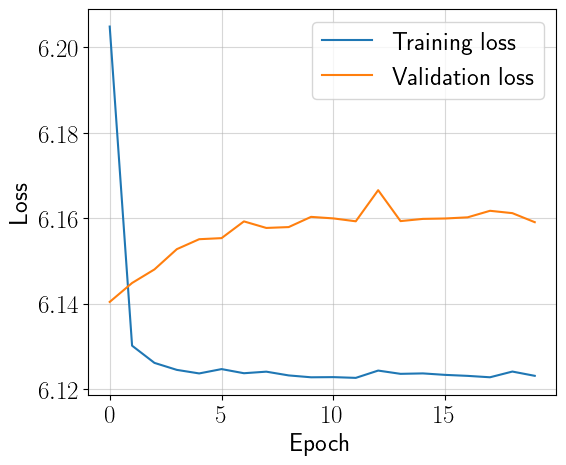

In [27]:
# Plot the training loss and the validation
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(model.history.history['loss'], label='Training loss')
ax.plot(model.history.history['val_loss'], label='Validation loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
ax.grid(which='both')
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)
fig.tight_layout()
plt.show()